<style>
/* Reveal container full viewport */
.reveal {
  width: 95vw !important; /* 95% of view width */
  height: 50vw !important;   /* about 16:9 aspect ratio height (width × 9/16) */
  max-width: 95vw !important;
  max-height: 50vw !important;
  margin: auto;
  font-size: 110%; /* global font size */
}

/* Slides filling container */
.reveal .slides {
  width: 100% !important;
  height: 100% !important;
  max-width: 100% !important;
  max-height: 100% !important;
  margin: auto;
  overflow-wrap: break-word;
}

/* Prevent content from overflowing horizontally */
.reveal section {
  overflow-x: auto;
  word-wrap: break-word;
  box-sizing: border-box;
  padding: 1em;
}

/* Tables scroll horizontally if too wide */
.reveal section table {
  display: block;
  overflow-x: auto;
  white-space: nowrap;
  max-width: 100%;
  margin: 0 auto;
  font-size: 90%;
  border-collapse: collapse;
}

/* Smaller font and compact padding inside table cells */
.reveal section table td,
.reveal section table th {
  font-size: 90%;
  padding: 0.3em 0.5em;
  white-space: nowrap;
}
</style>

# Third Hands-On Session
---
Exploring periodic lattices:

- Implementing and studying the properties of a FODO cell/lattice
- Computing closed optics solutions
- The concept of Tune and FODO cell phase advance
- Introducing Sector Bends
---

## 🐍 Python corner

Let's import standard packages and settings. We'll be using:
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- functions `D`, `Q`, `transportParticles`, `getEquivalentElement`

In [1]:
# Import custom tracking functions and useful libraries
from tracking_library import *

numpy is installed, version: 2.3.1
scipy is installed, version: 1.15.3
matplotlib is installed, version: 3.10.0
-> Setup is OK! Have fun!


## ⚛️ Physics focus: From arbitrary transport to periodic transport

From the previous lecture we know that any beam line can be described by a transfer matrix M. In a periodic system (e.g. an accelerator ring), the beam passes through the same structure repeatedly, so after m turns:
\begin{equation}
X_m = M \cdot M \cdot ... \cdot M X_0 = M^m X_0
\end{equation}
where M is the transfer matrix of one full period, also called **the One-Turn Map (OTM)**. 

For the motion to be stable over many turns, the particle trajectory must remain bounded:
\begin{equation}
|X_m| < |\hat{X}| \qquad  \forall \quad X_0, m
\end{equation}
For a 2x2 real symplectic matrix (such as M), this stability condition translates into a simple requirement on the trace:
\begin{equation}
\frac{1}{2}|Tr(M)|\leq1
\end{equation}

**In the following, we will study particle motion and stability using one of the most common periodic structures: the FODO cell!**


## 📝 Exercise 3.1: The FODO cell

Let's start working with FODO cells. This is one of the most fundamental lattice topologies. In its simpler version, it consists on two thin quadrupoles of opposite focal length, f, spaced by two drifts of length $L$ (as in [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)), i.e. the total length of the cell ($L_{FODO}$) is $2L$. 

<p align="center">
<img src=./_img_exercises/slide_fodo.png width="60%">
</p>

1. Define a **FODO beamline** that **starts and ends in the middle of a focusing quadrupole** (we could start the FODO from an arbitrary point inside it). For the moment, we can define arbitrarily the $f$ and $L$ parameters: we chose **2.5 m and 1 m**, respectively.

> 👀 **HINT 1**: A half-quadrupole has double the focal length than a full quadrupole.

> 👀 **HINT 2**: To better visualize the trajectory of the particle(s), always split the drifts in several shorter drifts (e.g. $10$ drifts, each $L/10$ long).
    
2. Track a particle that has an initial offset $x = 1$ mm and no angle $x' = -0.1$ mrad, and plot its position $x$ and angle $x'$ along the beam line.

> 👀 **HINT 3**: After having plotted $x$ trajectory on a plot, one can create a second vertical axis that shares the same horizontal axis with `plt.twinx()`

### Solution for 1. 

In [2]:
f = 2.5
L = 1
beamline = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)

### Solution for 2.

(-0.5, 0.5)

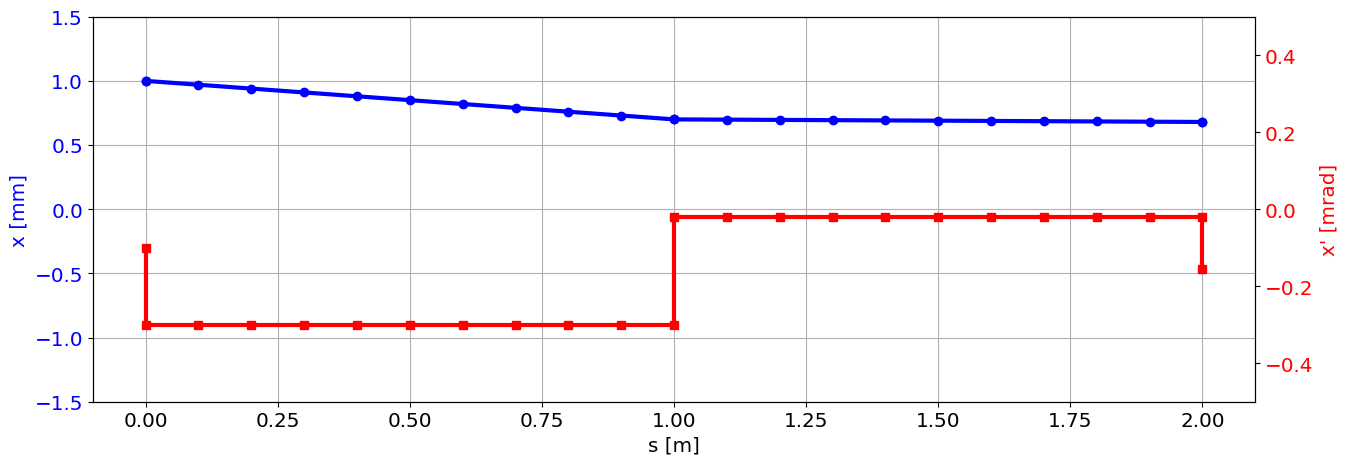

In [3]:
X = np.array([ [1], 
               [-0.1] ])

# do tracking
transported_particles = transportParticles(X, beamline)

# plotting
plt.plot(transported_particles["s"], transported_particles["x"], "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("x [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.ylim([-1.5, 1.5])

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_particles["s"], transported_particles["xp"], "s-r", lw=3)
plt.ylabel("x' [mrad]", color="r")
plt.ylim([-0.5, 0.5])

## 📝 Exercise 3.2: Multiple FODO cells - stability

1. Plot the position $x$ and angle $x'$ through $N=100$ equal FODO cells.
2. Play with different values of the focal length $f$ and explore whether you can make the oscillations grow.

> **Hint:** Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/):
>
> <p align="center">
> <img src=./_img_exercises/slide_stability.png width="60%">
> </p>
>
> It is shown that the stability of a FODO cell takes the form:
> \begin{equation}
    \frac{1}{2}|Tr(M)| = \left|\frac{L}{2f}\right| = \left|\frac{L_{FODO}}{4f}\right| \leq 1
   \end{equation}

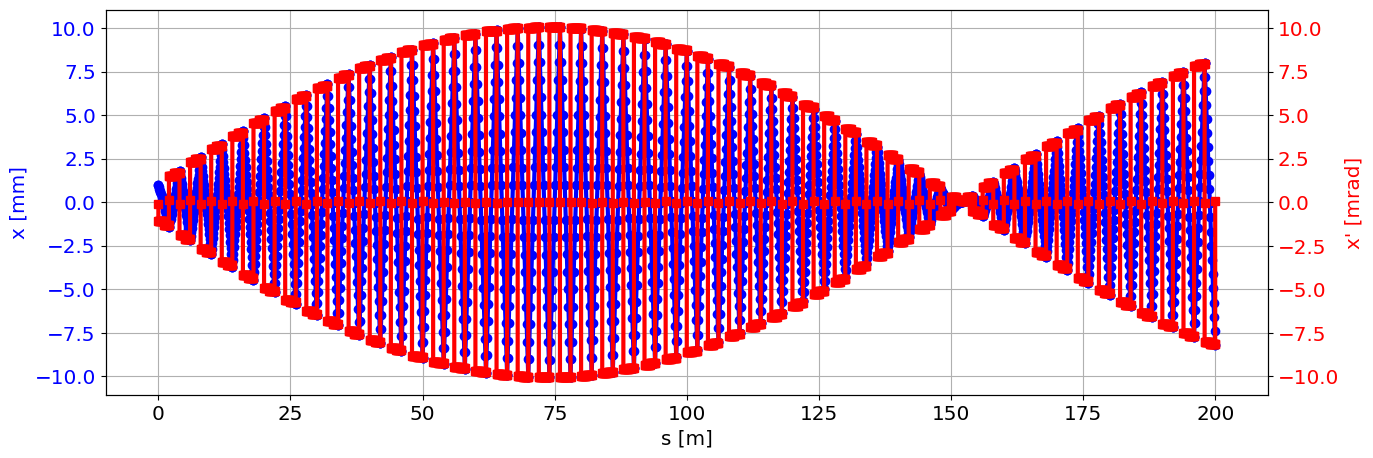

In [4]:
f = 0.5001
L = 1
beamline = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)

X = np.array([[1], [-0.1]])
transported_particles = transportParticles(X, 100 * beamline)

plt.plot(transported_particles["s"], transported_particles["x"], "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("x [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")

# instantiate a second axes that shares the same x-axis
ax2 = plt.twinx()
plt.ylabel("x' [mrad]", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_particles["s"], transported_particles["xp"], "s-r", lw=3)

## 📝 Exercise 3.3: Transport of sigma matrix in a FODO beamline & searching periodic solution

1. Transport a sigma matrix (e.g. $\beta$ = 3 [m], $\gamma$ = 0.5 [1/m], $\epsilon$ = 1) through a beamline made of 8 FODO cells (with, for example, $f=2.5$ and $L=1$ as before), and plot the evolution of the sigma matrix elements ($\sigma_{11}$, $\sigma_{22}$, $\sigma_{12}$) along the beamline. Do you see a periodic structure?

2. Try to vary the initial sigma matrix parameter by **try and error** that reproduces itself at the end of the beam line (8 FODO cells), meaning:

   \begin{equation}
      \Sigma_{0} = M_{\mathrm{OTM}} \Sigma_0 M_{\mathrm{OTM}}^T
   \end{equation}

 You will quickly realise that this is extremely difficult if not impossible. 

> 👀 **HINT 1**: (optional) you might want to use an **interactive plot** - see in the previous exercises how to make one

> 👀 **HINT 2**: **try!**, but **don't waist to much time with try and error** approaches (that's not your job as accelerator physicist!), and **move on** to the next exercise...

3. In a FODO cell the $\beta$ function reaches a maximum (or a minimum) in the middle of the quadrupoles, i.e. the $\alpha$ function is zero.
If one models the FODO cell starting from the middle of a quadrupole (as we do), then at least one parameter is fixed! 

### Solution for 1.

Text(0, 0.5, 'sigma12')

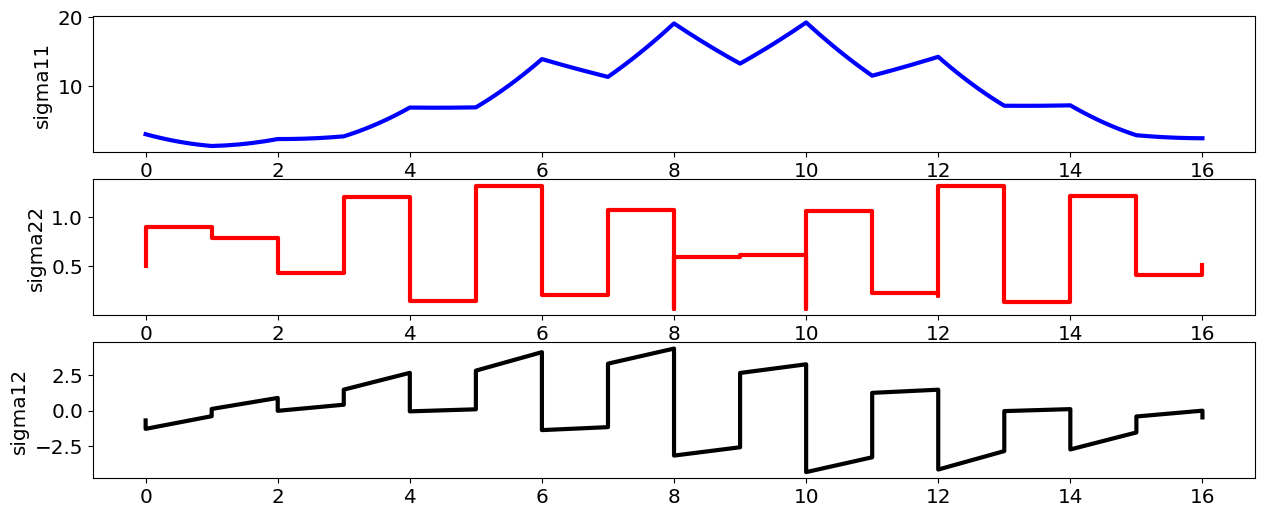

In [5]:
f = 2.5
L = 1
fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
fodo_lattice = 8 * fodo_cell

# define the initial sigma matrix
beta0 = 3
gamma0 = 0.5
epsilon0 = 1
# alfa must be:
alfa0 = np.sqrt(beta0 * gamma0 - 1)
sigma_0 = epsilon0 * np.array([[beta0, -alfa0], [-alfa0, gamma0]])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, fodo_lattice)
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "-b", lw=3)
plt.ylabel("sigma11")
plt.subplot(312)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma22"], "-r", lw=3)
plt.ylabel("sigma22")
plt.subplot(313)
plt.plot(transported_sigmas["s"], transported_sigmas["sigma12"], "-k", lw=3)
plt.ylabel("sigma12")

### Solution for 2. 

In [6]:
def plot_function(sigma11, sigma22, sigma12):
    # prepare the sigma matrix
    sigma0 = np.array([[sigma11, sigma12], [sigma12, sigma22]])

    output_b = transportSigmas(sigma0, fodo_lattice)
    plt.figure(figsize=(15, 6))
    plt.subplot(311)
    plt.plot(output_b["s"], output_b["sigma11"], "-b", lw=3)
    plt.ylabel("sigma11")
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b["s"], output_b["sigma22"], "-r", lw=3)
    plt.ylabel("sigma22")
    plt.grid(True)
    plt.subplot(313)
    plt.plot(output_b["s"], output_b["sigma12"], "-k", lw=3)
    plt.ylabel("sigma12")
    plt.grid(True)


interactive_plot = interactive(plot_function, sigma11=(10, 20, 0.1), sigma22=(0, 4, 0.1), sigma12=(-5, 5, 0.1), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

# **approximate** solution found by hand:
#plot_function(15.5, 0.4, 0)

interactive(children=(FloatSlider(value=15.0, description='sigma11', max=20.0, min=10.0), FloatSlider(value=2.…

### Solution for 3. 

In [7]:
# We can proceed again by try and error...
# define the basic FODO cell
f = 2.5
L = 1
fodo_cell = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
fodo_lattice = 8 * fodo_cell


def plot_function(sigma11, sigma22):
    # prepare the sigma matrix
    sigma0 = np.array([[sigma11, 0], [0, sigma22]])

    output_b = transportSigmas(sigma0, fodo_lattice)
    plt.figure(figsize=(15, 6))
    plt.subplot(311)
    plt.plot(output_b["s"], output_b["sigma11"], "-b", lw=3)
    plt.ylabel("sigma11")
    plt.grid(True)
    plt.subplot(312)
    plt.plot(output_b["s"], output_b["sigma22"], "-r", lw=3)
    plt.ylabel("sigma22")
    plt.grid(True)
    plt.subplot(313)
    plt.plot(output_b["s"], output_b["sigma12"], "-k", lw=3)
    plt.ylabel("sigma12")
    plt.grid(True)


interactive_plot = interactive(plot_function, sigma11=(0, 25, 0.1), sigma22=(0, 4, 0.1), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

interactive(children=(FloatSlider(value=12.0, description='sigma11', max=25.0), FloatSlider(value=2.0, descrip…

## ⚛️ Physics focus: Periodic solution (matching)

Even when the motion is stable, the beam size (described by the sigma matrix $\Sigma$) may vary strongly from cell to cell or turn to turn. This can cause undesirable effects such as beam losses or emittance growth in the presence of nonlinearities.

In a circular accelerator, we usually want more than just bounded motion: we want the beam shape (phase space ellipse) to remain the same every turn. This special situation is called a **matched beam**, and it is defined by the condition:

   \begin{equation}
      \Sigma_{0} = M_{\mathrm{OTM}} \Sigma_0 M_{\mathrm{OTM}}^T
   \end{equation}

A beam satisfying this relation is in equilibrium with the lattice and remains stationary from turn to turn.


**Recalling** [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/): if we parameterize the beam with the Twiss parameters, the one-turn matrix of any stable beam line can be written as:

\begin{equation}
M_{\mathrm{OTM}} = 
    \left[
    \begin{array}{cc}
    \cos(\mu) + \alpha_0 \sin(\mu)  & \beta_0 \sin(\mu)\\
    - \gamma_0 \sin(\mu) & \cos(\mu) - \alpha_0 \sin(\mu)
    \end{array}
    \right]
    =
    \left[
    \begin{array}{cc}
    r_{11}  & r_{12} \\
    r_{21}  & r_{22}
    \end{array}
    \right]
\end{equation}

where $\alpha_0$, $\beta_0$, $\gamma_0$ are the initial (and final) **Twiss values** and $\mu$ is the phase advance (or **tune**, if we talk about a whole ring) of the associated beamline.


**From this representation one can directly extract the periodic Twiss parameters of any beamline, provided a stable solution exists, i.e. $\frac{1}{2}|\mathrm{Tr}(M)| \le 1$**

## 📝 Exercise 3.4: Matching to FODO lattice (periodic solution)

One can use the equation form [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/) to find the theoretical solution.

<p align="center">
<img src=./_img_exercises/slide_fodo_periodic.png width="60%">
</p>

Get the one turn matrix of the previous beamline using the `getEquivalentElement` function and extract the matching initial conditions. 

np.float64(-6.123724356957298)

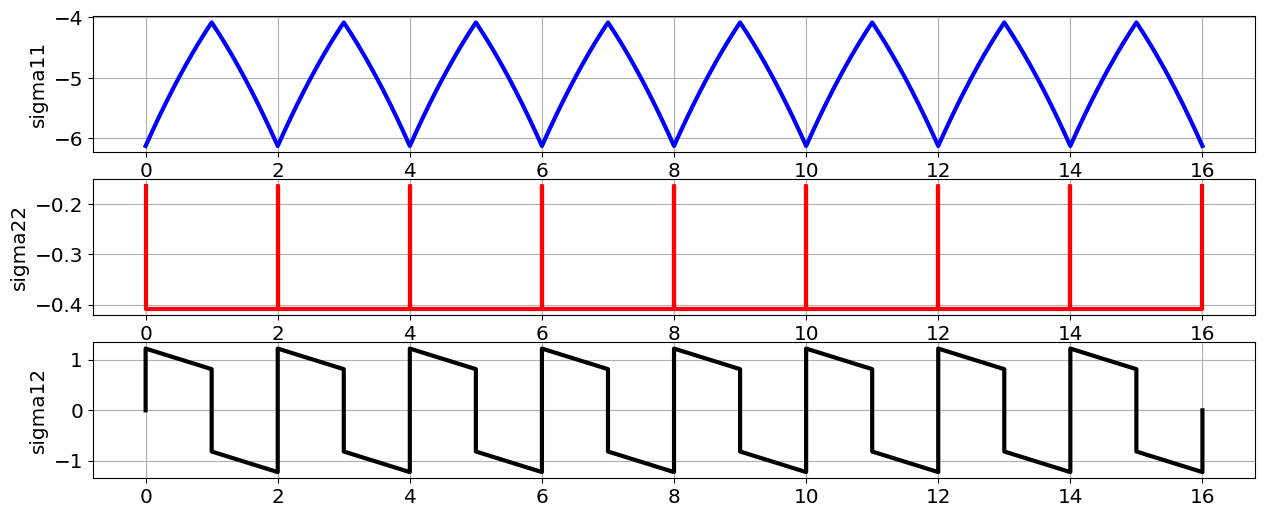

In [8]:
# get the one turn matrix:
fodo_lattice_reduced = getEquivalentElement(fodo_lattice)
# extract the matched initial conditions
sigma11 = fodo_lattice_reduced[0]["matrix"][0, 1] / np.sqrt(1 - (fodo_lattice_reduced[0]["matrix"][0, 0]) ** 2)
sigma22 = 1 / sigma11
sigma12 = 0
# plot the solution (using function from previous exercise)
plot_function(sigma11, sigma22)

# print values
sigma11

### 🔹 **NOTE** Those concepts are implemented in the function `twiss()` from our toolbox:

In [9]:
from tracking_library import twiss

help(twiss)

Help on function twiss in module tracking_library:

twiss(beamline)
    Compute Twiss parameters and tune for a periodic beamline.

    Parameters
    ----------
    beamline : list of dict
        Sequence of beamline elements.

    Returns
    -------
    tune : float
        Betatron tune (fraction of oscillation per turn).
    beta : float
        Beta function at entrance [m].
    alpha : float
        Alpha function at entrance.
    gamma : float
        Gamma function at entrance.



> 🔹 **NOTE**: We can apply this function to any beamline, e.g. a series of quadrupoles and drifts, e.g.:

In [10]:
# create a random beamline of many elements
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + 10 * D(1.5 / 10))

# compute the closed solution
(tune, beta, alpha, gamma) = twiss(beamline)

# assemble the sigma matrix
sigma_matrix = np.array([[beta, -alpha], [-alpha, gamma]])

# print out the values
print(f"The total phase advance (or tune) of the beamline is {tune}.")
print(f"The sigma matrix is:\n {sigma_matrix}")
print(f"which has determinant equal to: {np.linalg.det(sigma_matrix):.3f}.")

The total phase advance (or tune) of the beamline is 0.5999038489602736.
The sigma matrix is:
 [[16.98880317 14.57092107]
 [14.57092107 12.55601932]]
which has determinant equal to: 1.000.


❓**QUESTION: why the determinant of the obtained sigma matrix is equal to 1?**

## 📝 Exercise 3.5: Matching single FODO cell using `twiss`

Consider again a FODO cell, and choose $f$ and $L$ making sure it allows for having a periodic solution (i.e. $|f| > L_{FODO}/4$ - see again [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)). 
This time, **model the FODO cell starting from the middle of a drift**, i.e. `D(L/2) + Q(f) + D + Q(-f) + D(L/2)`.

1. Compute the periodic $\Sigma_0$ matrix using the Twiss parameters obtain for the newly defined `twiss` function (assuming $\epsilon=1$).
2. Transport the periodic $\Sigma$ matrix along the FODO and convince yourself that the $\Sigma_s$ matrix at the end of the FODO is indeed equal to the one at the start, $\Sigma_0$.

### Solution for 1. 

In [11]:
f = 2.5
L = 2
fodo_cell = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)

# compute closed solution
tune, beta, alpha, gamma = twiss(fodo_cell)
# build sigma matrix
sigma_0 = np.array([[beta, -alpha], [-alpha, gamma]])

### Solution for 2. 

Initial Sigma: 
[[5.01901148 1.09108945]
 [1.09108945 0.43643578]]
Final Sigma: 
[[5.01901148 1.09108945]
 [1.09108945 0.43643578]]


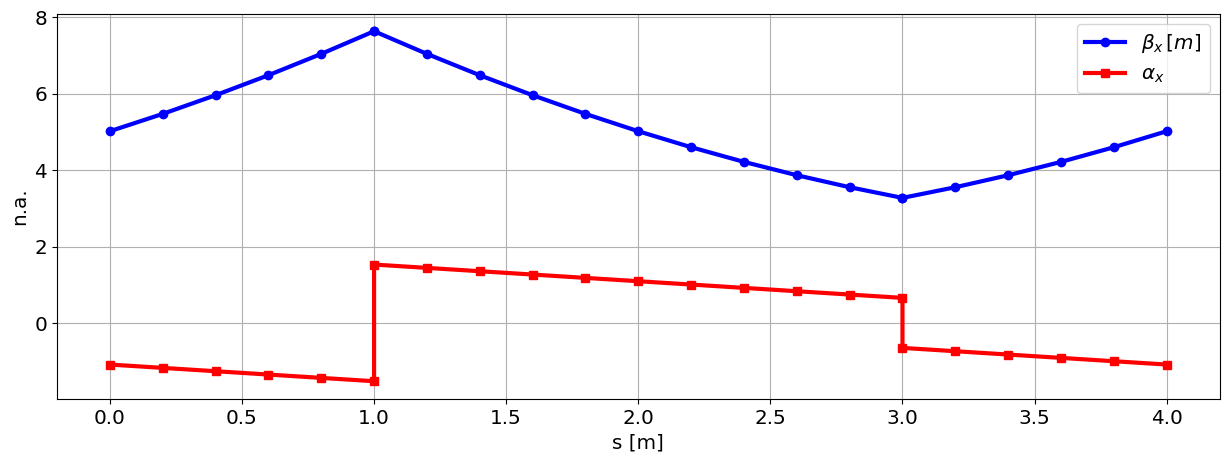

In [12]:
# transport it
transported_sigmas = transportSigmas(sigma_0, fodo_cell)

plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "o-b", lw=3, label=r"$\beta_x\, [m]$")
plt.plot(transported_sigmas["s"], -transported_sigmas["sigma12"], "s-r", lw=3, label=r"$\alpha_x$")

plt.grid(True)
plt.legend(loc="best")
plt.xlabel("s [m]")
plt.ylabel("n.a.")

print(f"Initial Sigma: \n{transported_sigmas['sigmas'][0,:,:]}")
print(f"Final Sigma: \n{transported_sigmas['sigmas'][-1,:,:]}")

## 📝 Exercise 3.6: Evolution of a matched simga matrix in multiple FODO cells
Write down the numerical values of initial beam matrix $\Sigma_0$, then build a beam line made of $15$ consecutive cells by changing the definition of the lattice and then, using $\Sigma_0$ with the noted-down numbers, prepare a plot of the beam sizes along the $15$ cells. 
Is this also periodic?

Text(0.5, 0, 's [m]')

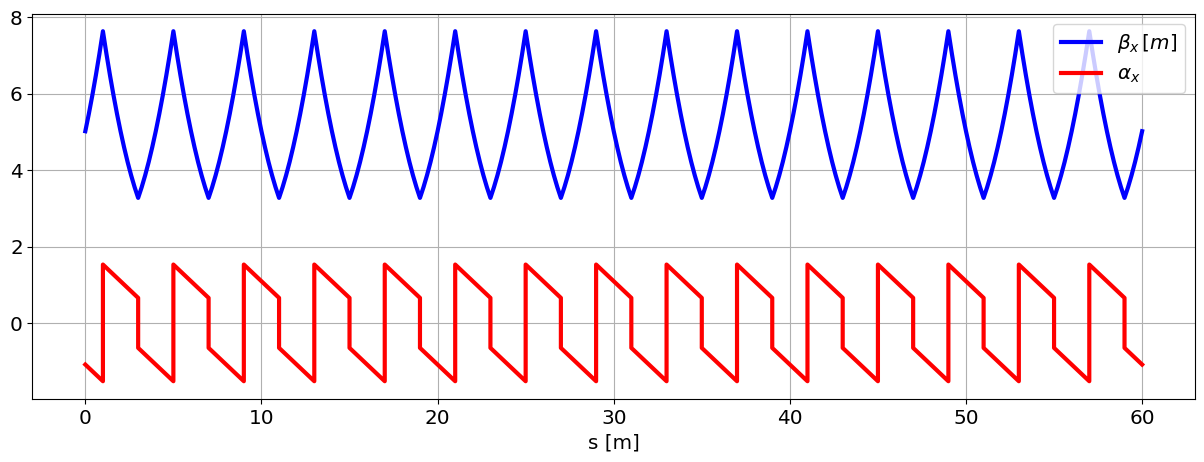

In [13]:
# as before:
f = 2.5
L = 2
fodo_cell = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)
tune, beta, alpha, gamma = twiss(fodo_cell)
sigma_0 = np.array([[beta, -alpha], [-alpha, gamma]])

# transport the solution found on a single cell over 15 cells
transported_sigmas = transportSigmas(sigma_0, 15 * fodo_cell)

plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "-b", lw=3, label=r"$\beta_x\, [m]$")
plt.plot(transported_sigmas["s"], -transported_sigmas["sigma12"], "-r", lw=3, label=r"$\alpha_x$")
plt.grid(True)
plt.legend(loc="best")
plt.xlabel("s [m]")

## 📝 Exercise 3.7: Trace (phase) space ellipse

Consider the previous FODO cell starting in the middle of the drift, and stable. 
Consider a single particle with some non-zero initial $x_0$ and $x_0'$ (e.g. $x_0 =.24$; $x' = 2.3$), and **plot the $x$, $x'$ coordinates at the end of each FODO cell** for a beamline made of 100 cells. 

> 👀 **HINT 1**: You should use both `getEquivalentElement` to obtain the single FODO cell element, and `transportParticles` function to track the particle over several of such a cell.

> 👀 **HINT 2**: use `plt.scatter(output['x'], output['px'])` to plot all phase-space coordinates.

In [14]:
# create the cell
f = 2.5
L = 2
fodo_cell = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)

# compute the one turn map:
OTM = getEquivalentElement(fodo_cell)


def plot_function(x, xp):
    particle = [[x], [xp]]
    transported_particles = transportParticles(particle, 100 * OTM)
    plt.scatter(transported_particles["x"], transported_particles["xp"], c=transported_particles["s"] / (L * 2))
    cb = plt.colorbar()
    cb.set_label("Turns")
    plt.xlabel("x [mm]")
    plt.ylabel("x' [mrad]")
    plt.xlim(-13, 13)
    plt.ylim(-5, 5)
    plt.grid(True)


interactive_plot = interactive(plot_function, x=(-2, 2, 0.1), xp=(-2, 2, 0.1), continuous_update=True)
output = interactive_plot.children[-1]
output.layout.height = "500px"
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

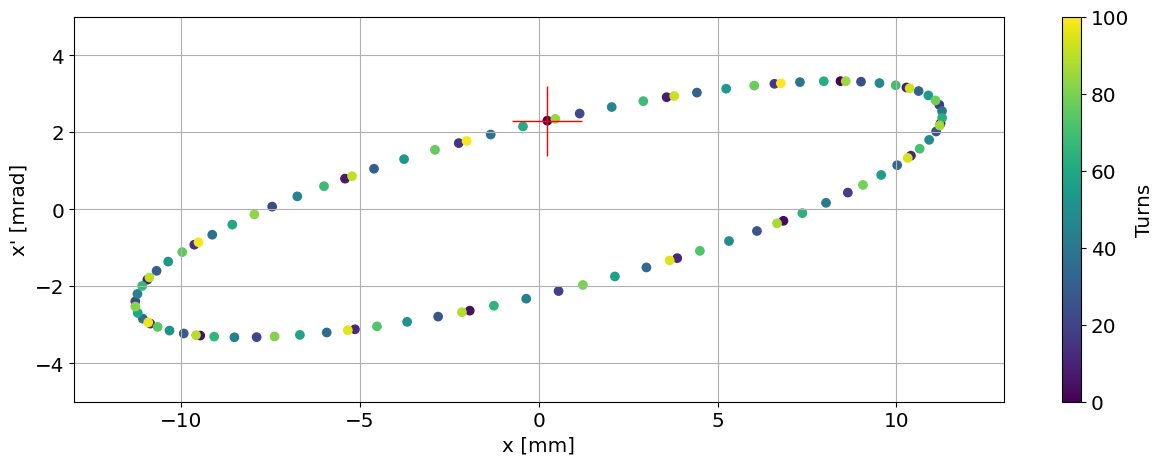

In [15]:
#  An example of static plot for saving...
x = 0.24
xp = 2.3
plot_function(x, xp)
plt.plot(x, xp, "+r", ms=50)

### 🔹 NOTE: the Twiss parameters get a special meaning

<p align="center">
<img src=./_img_exercises/ellipse.png width="40%">
</p>

## 📝 Exercise 3.8: Betatron oscillations
Consider again the previous FODO cell, and a particle starting with non-zero coordinates. Plot the position of the particle vs the number of turns. 

1. What do you observe?
2. Can you infer the tune? 
3. How many turns (or FODO cells) are needed for the particle to complete one full oscillation?
4. What changes if you start from a different initial coordinate?

The expected single-cell tune is 0.131.
 => Over 100 one expects to see 13.099 oscillations!


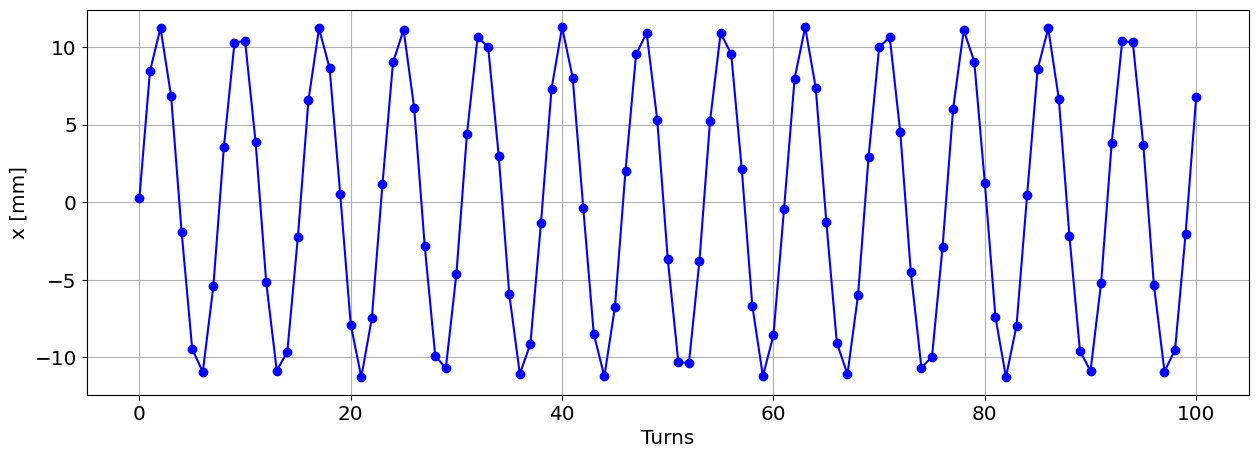

In [16]:
# build the FODO cell
f = 2.5
L_2 = 2
fodo_lattice = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)
# compute one turn matrix
OTM = getEquivalentElement(fodo_lattice)

# define initial coordinates
x = 0.24
xp = 2.3
particle = [[x], [xp]]

n_turns = 100
transported_particles = transportParticles(particle, n_turns * OTM)

plt.plot(transported_particles["s"] / (L * 2), transported_particles["x"], "o-b")
plt.xlabel("Turns")
plt.ylabel("x [mm]")
plt.grid(True)

# let's compute the tune from the OTM
tune, beta, alpha, gamma = twiss(OTM)
print(f"The expected single-cell tune is {tune:.3f}.")
print(f" => Over {n_turns} one expects to see {n_turns*tune:.3f} oscillations!")

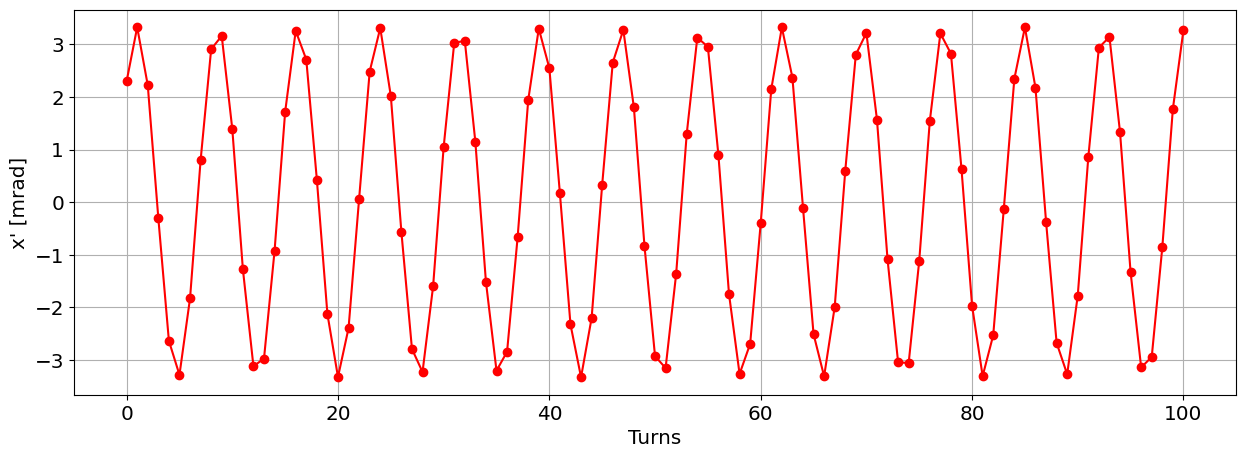

In [17]:
plt.plot(transported_particles["s"] / (L_2 * 2), transported_particles["xp"], "o-r")
plt.xlabel("Turns")
plt.ylabel("x' [mrad]")
plt.grid(True)

## 📝 Exercise 3.9: Tuning FODO phase advance

Consider a single FODO cell of total length $L_{FODO}=2$ m. 

1. Can you find $f$ such that the FODO cell phase advance is $\mu = \pi/2$, i.e. 90 deg phase-advance?
2. Repeat this cell 100 times, and plot the trajectory, in phase space, of a particle with x=1 mm and xp=0 cell after cell: what do you observe?
3. (Optional) Show that the similar results are obtained irrespectively if you start your FODO from the middle of a quadrupole or of a drift.

> 👀 **HINT**: Look back at [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/):
>
> <p align="center">
> <img src=./_img_exercises/slide_fodo_phase.png width="60%">
> </p>
> 
> and recall that $\mathrm{Tr}(M) = 2 \cos(\mu)$. 
> With some math, one can prove that:
> 
>    \begin{equation}
       \sin(\mu/2) = \frac{L_{FODO}}{4f}
    \end{equation}

In [18]:
# let's build up the FODO cell using the provided inputs
L_2 = 2
desired_mu = np.pi / 2

f = L_2 / (4 * np.sin(desired_mu / 2))
L = L_2 / 2

# fodo starting from the middle of a quad
fodo_lattice_1 = Q(2 * f) + 10 * D(L / 10) + Q(-f) + 10 * D(L / 10) + Q(2 * f)
# or drift
fodo_lattice_2 = 5 * D(L / 10) + Q(f) + 10 * D(L / 10) + Q(-f) + 5 * D(L / 10)

tune, beta, alpha, gamma = twiss(fodo_lattice_1)
print(f"Fodo starting in the quad: tune is {tune}.")
tune, beta, alpha, gamma = twiss(fodo_lattice_2)
print(f"Fodo starting in the drift: tune is {tune}.")

Fodo starting in the quad: tune is 0.24999999999999986.
Fodo starting in the drift: tune is 0.24999999999999992.


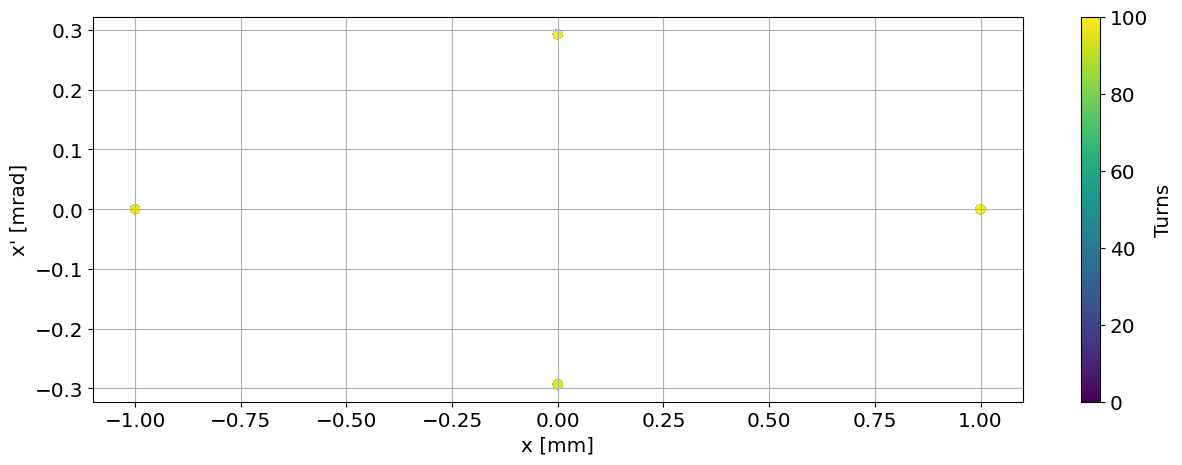

In [19]:
# generate a particle
x = 1
xp = 0
particle = [[x], [xp]]

# track the particle over 100 cells
OTM = getEquivalentElement(fodo_lattice_1)
transported_particles = transportParticles(particle, 100 * OTM)

# plot tracked particles as well as ellipse
plt.scatter(transported_particles["x"], transported_particles["xp"], c=transported_particles["s"] / (L * 2))
cb = plt.colorbar()
cb.set_label("Turns")
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.grid(True)

## 📝 Exercise 3.10: Tuning a FODO cell with dipoles

Build a beam line made of 6 FODO cells with $L_{cell} = 4$ m and **Adjust the value of f** such that one cell phase advance is **60 degrees**.

1. Compute the closed optics using the `twiss()` function on a **single cell**, and plot the **beta function** along the whole beamline. Can you also compute the closed optics solution **applying twiss() to the whole beamline**? Does the solution differ? Why? What is the "tune" of the whole beamline?
2. Introduce **sector bends** ($L_{bend} = L_{DRIFT}/2 = 1$ m, and bending angle $\phi=10$ degrees) in the middle of all drifts of the FODO cells, without changing the total length of the FODO cell. How does the optics change?
3. Try to adjust the focal length of the quadrupoles to recover **60 degrees** phase advance **per cell**.

 > 👀 **HINT**: Our toolbox library implements also sector bends: `B(phi, L)` defined by bending angle (`phi`) and bend lenght (`L`).

In [20]:
# Import the sector bend model
from tracking_library import B

help(B)

Help on function B in module tracking_library:

B(phi, L)
    Thick sector bend with deflecting angle phi and length L (2x2 matrix).

    Parameters
    ----------
    phi : float
        Deflection angle [rad]
    L : float
        Length of the bend [m]

    Returns
    -------
    element : list of dict
        A list with a single dictionary containing the matrix and length.




    The phase per cell is: 0.16666666666666663
    The beta is: 4.0414518843273814 m
    The alpha is: -1.1547005383792515 
    The gamma is: 0.5773502691896255


    The phase of the whole beamline is: 4.743186923619966e-09
    The beta is: 3.9115548133850104e-08 m
    The alpha is: -1.8626451492309574e-09 
    The gamma is: 25565281.52380952



Text(0, 0.5, '$\\beta_x\\ [m]$')

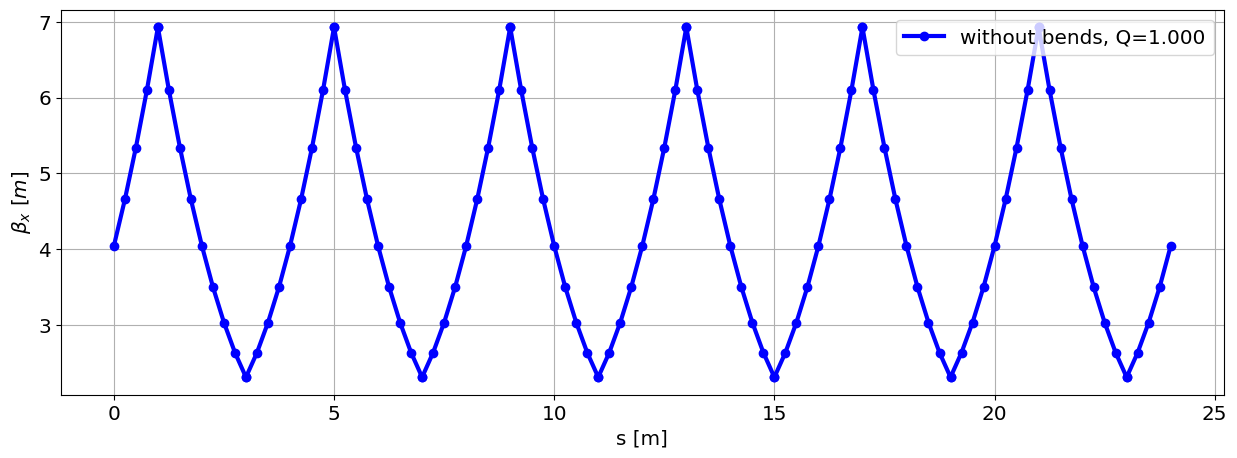

In [21]:
# parameters for the beamline without bends
n_cells = 6
bend_angle = 10 * np.pi / 180
L_2 = 4
L = L_2 / 2
desired_mu = 60 * np.pi / 180
f = L_2 / (4 * np.sin(desired_mu / 2))

# without bends
fodo_cell = 4 * D(L / 8) + Q(f) + 8 * D(L / 8) + Q(-f) + 4 * D(L / 8)
beamline = n_cells * fodo_cell

# compute twiss without bends #########
(phase, beta, alpha, gamma) = twiss(fodo_cell)
sigma_0 = np.array([[beta, -alpha], [-alpha, gamma]])
transported_sigmas = transportSigmas(sigma_0, beamline)
# compute the total tune, as repetition of the phase advance of each cell.
tune = n_cells * phase

print(
    f"""
    The phase per cell is: {phase}
    The beta is: {beta} m
    The alpha is: {alpha} 
    The gamma is: {gamma}
"""
)

# trying to apply twiss to the whole beamline:
(phase_total, beta_total, alpha_total, gamma_total) = twiss(beamline)

print(
    f"""
    The phase of the whole beamline is: {phase_total}
    The beta is: {beta_total} m
    The alpha is: {alpha_total} 
    The gamma is: {gamma_total}
"""
)

# plot the optics
plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "o-b", lw=3, label=f"without bends, Q={tune:.3f}")

plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r"s [m]")
plt.ylabel(r"$\beta_x\ [m]$")

Text(0, 0.5, '$\\beta_x\\ [m]$')

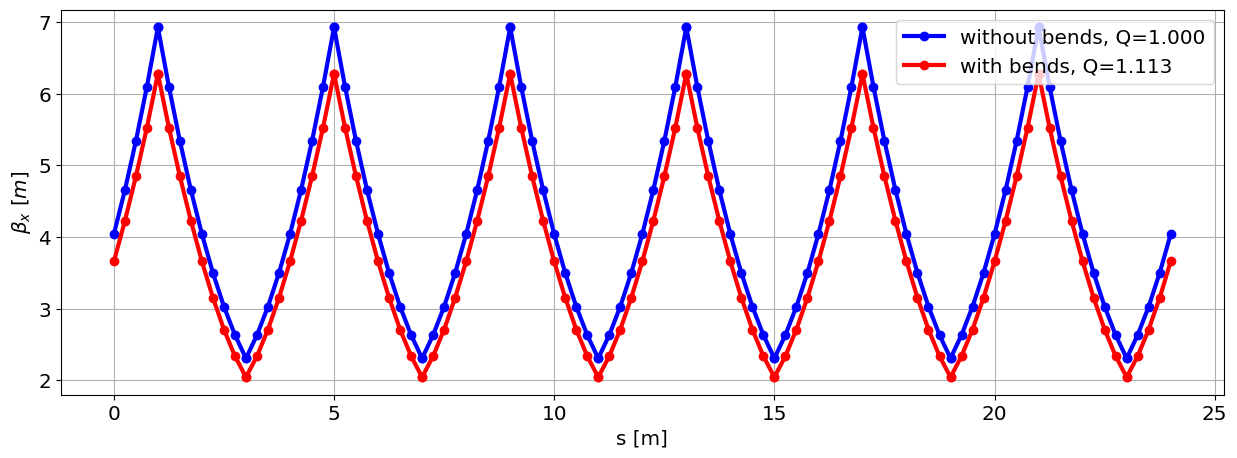

In [22]:
# Reproduce the beamline with bends (splitting bends in a few pieces, just to have more points in the plots...)
fodo_cell_bend = (
    2 * B(bend_angle / 4, L / 8)
    + 2 * D(L / 8)
    + Q(f)
    + 2 * D(L / 8)
    + 4 * B(bend_angle / 4, L / 8)
    + 2 * D(L / 8)
    + Q(-f)
    + 2 * D(L / 8)
    + 2 * B(bend_angle / 4, L / 8)
)
beamline_bend = n_cells * fodo_cell_bend

# compute twiss with bends ###########
(phase_bend, beta_bend, alpha_bend, gamma_bend) = twiss(fodo_cell_bend)
sigma_0_bend = np.array([[beta_bend, -alpha_bend], [-alpha_bend, gamma_bend]])
transported_sigmas_bend = transportSigmas(sigma_0_bend, beamline_bend)
tune_bend = n_cells * phase_bend

# plot
plt.plot(transported_sigmas["s"], transported_sigmas["sigma11"], "o-b", lw=3, label=f"without bends, Q={tune:.3f}")
plt.plot(transported_sigmas_bend["s"], transported_sigmas_bend["sigma11"], "o-r", lw=3, label=f"with bends, Q={tune_bend:.3f}")

plt.grid(True)
plt.legend(loc="best")
plt.xlabel(r"s [m]")
plt.ylabel(r"$\beta_x\ [m]$")

> 🔹 **NOTE:** the optics has completly changed, so the tune. Why? Extra-focusing from sector bends...

In [23]:
# The beamline with bends has clearly much more horizontal focusing, hence let's try to increase f (i.e. reduce the strength of quads)
f_new = 1.13043 * f
fodo_cell_bend_new = (
    2 * B(bend_angle / 4, L / 8)
    + 2 * D(L / 8)
    + Q(f_new)
    + 2 * D(L / 8)
    + 4 * B(bend_angle / 4, L / 8)
    + 2 * D(L / 8)
    + Q(-f_new)
    + 2 * D(L / 8)
    + 2 * B(bend_angle / 4, L / 8)
)
(tune_cell_bend_new, _, _, _) = twiss(fodo_cell_bend_new)

print(tune_cell_bend_new)

0.16666680402320802


## Well done !!

=> **If you still have time, continue your learning with the following [notebook](./04_Dispersion.ipynb)**...
